In [1]:
#matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from dataset.dataloader import *
import operators as ops
import torch
import os

CKPT_DIR = "./logs/checkpoints"
LOAD_PRETRAINED = True

In [2]:
import torch.nn as nn
import torch

class torch_VGG8(nn.Module):
    def __init__(self):
        super(torch_VGG8, self,).__init__()
        # Layer 1 (B, 1, 28, 28) -> (B, 32, 28, 28)
        self.Layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 2 (B, 32, 28, 28) -> (B, 64, 14, 14)
        self.Layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Layer 3 (B, 64, 14, 14) -> (B, 64, 14, 14)
        self.Layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 4 (B, 64, 14, 14) -> (B, 128, 7, 7)
        self.Layer4 =nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Layer 5 (B, 128, 7, 7) -> (B, 256, 7, 7)
        self.Layer5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 6 (B, 256, 7, 7) -> (B, 256, 7, 7)
        self.Layer6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(True)
        )
        # Layer 7 (B, 256*7*7) -> (B, 256)
        self.Layer7 = nn.Sequential(
            nn.Linear(in_features=256*7*7, out_features=256, bias=True,),
            nn.ReLU(True)
        )
        # Layer 8 (B, 256) -> (B, 10)
        self.Layer8 = nn.Sequential(
            nn.Linear(in_features=256, out_features=10, bias=True,),
        )

    def forward(self, x):
        # L1~L6: Conv + ReLU + (MaxPool)
        x = self.Layer1(x)
        x = self.Layer2(x)
        x = self.Layer3(x)
        x = self.Layer4(x)
        x = self.Layer5(x)
        x = self.Layer6(x)
        # L7: FC + ReLU
        x = x.view(x.size(0), -1)
        x = self.Layer7(x)
        # L8: FC
        x = self.Layer8(x)
        return x


In [3]:
class VGG8:
    def __init__(self):
        self.criterion = ops.SoftmaxWithLoss()
        self.conv_layers = [
            # Layer 1 (B, 1, 28, 28) -> (B, 32, 28, 28)
            ops.Conv2D(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1, name="L1_C"),
            ops.ReLU(name="L1_R"),

            # Layer2 (B, 32, 28, 28) -> (B, 64, 14, 14)
            ops.Conv2D(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1, name="L2_C"),
            ops.ReLU(name="L2_R"),
            ops.MaxPooling(kernel_size=2, stride=2, name="L2_M"),
            
            # Layer 3 (B, 64, 14, 14) -> (B, 64, 14, 14)
            ops.Conv2D(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1, name="L3_C"),
            ops.ReLU(name="L3_R"),

            # Layer 4 (B, 64, 14, 14) -> (B, 128, 7, 7)
            ops.Conv2D(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1, name="L4_C"),
            ops.ReLU(name="L4_R"),
            ops.MaxPooling(kernel_size=2, stride=2, name="L4_M"),

            # Layer 5 (B, 128, 7, 7) -> (B, 256, 7, 7)
            ops.Conv2D(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1, name="L5_C"),
            ops.ReLU(name="L5_R"),

            # Layer 6 (B, 256, 7, 7) -> (B, 256, 7, 7)
            ops.Conv2D(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, name="L6_C"),
            ops.ReLU(name="L6_R")
        ]

        # Layer 7 (B, 256*7*7) -> (B, 256)
        self.fc_layers = [
            ops.FullyConnected(in_feature=256*7*7, out_feature=256, name="L7_FC"),
            ops.ReLU(name="L7_R"),

        # Layer 8 (B, 256) -> (B, 10)
            ops.FullyConnected(in_feature=256, out_feature=10, name="L8_FC")
        ]

    def backprop(self, lr, m=None) -> None:
        # Backward
        #dout = self.criterion.backward(pred, label)
        dout = self.criterion.backward()
        for i in range(len(self.fc_layers)-1, -1, -1):
            dout = self.fc_layers[i].backward(dout)
        dout = dout.reshape(dout.shape[0], 256, 7, 7)
        for i in range(len(self.conv_layers)-1, -1, -1):
            dout = self.conv_layers[i].backward(dout)
        # Update
        for layer in self.conv_layers:
            layer.update(lr, m)
        for layer in self.fc_layers:
            layer.update(lr, m)
        return dout

    def forward(self, x: np.ndarray):
        i = 0
        for layer in self.conv_layers:
            i+=1
            x = layer.forward(x) 
        x = x.reshape(x.shape[0],-1)
        for layer in self.fc_layers:
            x = layer.forward(x)
        return x

    def save(self, fileName: str):
        with open(fileName, "wb") as f:
            pickle.dump(self, f)

    def load(self, fileName: str):
        with open(fileName, "rb") as f:
            self = pickle.load(f)

In [4]:
model = VGG8()

In [5]:
if LOAD_PRETRAINED:
    # Load pretrained weights from torch
    torch_vgg8 = torch_VGG8()
    torch_vgg8.load_state_dict(torch.load("torch_vgg8.pt"))

    for i, p in enumerate(torch_vgg8.Layer1.parameters()):
        if (i == 0):
            print(f"Load L1 Weight:({p.shape},{model.conv_layers[0].W.shape})")
            model.conv_layers[0].W = p.detach().numpy()
        else:
            print(f"Load L1 Bias({model.conv_layers[0].b.shape},{p.shape})")
            model.conv_layers[0].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer2.parameters()):
        print(torch_vgg8.Layer2)
        if (i == 0):
            print(f"Load L2 Weight:({p.shape},{model.conv_layers[2].W.shape})")
            model.conv_layers[2].W = p.detach().numpy()
        else:
            print(f"Load L2 Bias({model.conv_layers[2].b.shape},{p.shape})")
            model.conv_layers[2].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer3.parameters()):
        if (i == 0):
            print(f"Load L3 Weight:({p.shape},{model.conv_layers[5].W.shape})")
            model.conv_layers[5].W = p.detach().numpy()
        else:
            print(f"Load L3 Bias({model.conv_layers[5].b.shape},{p.shape})")
            model.conv_layers[5].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer4.parameters()):
        if (i == 0):
            print(f"Load L4 Weight:({p.shape},{model.conv_layers[7].W.shape})")
            model.conv_layers[7].W = p.detach().numpy()
        else:
            print(f"Load L4 Bias({model.conv_layers[7].b.shape},{p.shape})")
            model.conv_layers[7].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer5.parameters()):
        if (i == 0):
            print(f"Load L5 Weight:({p.shape},{model.conv_layers[10].W.shape})")
            model.conv_layers[10].W = p.detach().numpy()
        else:
            print(f"Load L5 Bias({model.conv_layers[10].b.shape},{p.shape})")
            model.conv_layers[10].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer6.parameters()):
        if (i == 0):
            print(f"Load L6 Weight:({p.shape},{model.conv_layers[12].W.shape})")
            model.conv_layers[12].W = p.detach().numpy()
        else:
            print(f"Load L6 Bias({model.conv_layers[12].b.shape},{p.shape})")
            model.conv_layers[12].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer7.parameters()):
        if (i == 0):
            print(f"Load L7 Weight:({p.shape},{model.fc_layers[0].W.shape})")
            model.fc_layers[0].W = p.T.detach().numpy()
        else:
            print(f"Load L7 Bias({model.fc_layers[0].b.shape},{p.shape})")
            model.fc_layers[0].b = p.detach().numpy()
    for i, p in enumerate(torch_vgg8.Layer8.parameters()):
        if (i == 0):
            print(f"Load L8 Weight:({p.shape},{model.fc_layers[2].W.shape})")
            model.fc_layers[2].W = p.T.detach().numpy()
        else:
            print(f"Load L8 Bias({model.fc_layers[2].b.shape},{p.shape})")
            model.fc_layers[2].b = p.detach().numpy()

Load L1 Weight:(torch.Size([32, 1, 3, 3]),(32, 1, 3, 3))
Load L1 Bias((32,),torch.Size([32]))
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Load L2 Weight:(torch.Size([64, 32, 3, 3]),(64, 32, 3, 3))
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Load L2 Bias((64,),torch.Size([64]))
Load L3 Weight:(torch.Size([64, 64, 3, 3]),(64, 64, 3, 3))
Load L3 Bias((64,),torch.Size([64]))
Load L4 Weight:(torch.Size([128, 64, 3, 3]),(128, 64, 3, 3))
Load L4 Bias((128,),torch.Size([128]))
Load L5 Weight:(torch.Size([256, 128, 3, 3]),(256, 128, 3, 3))
Load L5 Bias((256,),torch.Size([256]))
Load L6 Weight:(torch.Size([256, 256, 3, 3]),(256, 256, 3, 3))
Load L6 Bias((256,),torch.Size([256]))
Load L7 Weight:(torc

In [6]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

batch_size = 50
learning_rate = 0.01
#momentum = 0.9
momentum = None
loss_print_time = 5
accuracy_print_time = loss_print_time * 5
x_log = []
loss_log = []

print(f"Train:{x_train.shape}, Test:{x_test.shape}")

def accuracy_check(model, x_test, t_test, test_size):
    total_correct = 0

    test_data_idx = np.random.choice(x_test.shape[0], test_size)
    for i in tqdm(test_data_idx):
        x = x_test[i].reshape(1, 1, 28, 28)
        labels = t_test[i]

        outputs = model.forward(x)
        labels = labels.reshape(outputs.shape)
        c = (np.argmax(labels, 1) == np.argmax(outputs, 1)).squeeze()
        total_correct += np.sum(c)
    return total_correct/test_size
    #print(f"Accuracy:{total_correct/test_size}")


Train:(60000, 784), Test:(10000, 784)


In [7]:
for epoch in range(10):
    accuracy = 0.0
    train_size = x_train.shape[0]
    running_loss = []
    for i, b in tqdm(enumerate(range(0, train_size, batch_size))):
        x = x_train[b:b+batch_size].reshape(batch_size, 1, 28, 28)   # B, C, H, W
        labels = t_train[b:b+batch_size]
        #optimizer.zero_grad()

        outputs = model.forward(x)
        loss = model.criterion.forward(outputs, labels)
        running_loss.append(loss)
        model.backprop(learning_rate, momentum)

        if (i % loss_print_time == 0):
            if (i % accuracy_print_time == 0):
                print(f'[epoch:{epoch}, data num:{b}] Avg Loss: {sum(running_loss)/len(running_loss):.6f}, Max Loss: {max(running_loss):.6f}, Min Loss: {min(running_loss):.6f}, Accuracy: {accuracy_check(model, x_test, t_test, 100)}')
            else:
                print(f'[epoch:{epoch}, data num:{b}] Avg Loss: {sum(running_loss)/len(running_loss):.6f}, Max Loss: {max(running_loss):.6f}, Min Loss: {min(running_loss):.6f}')
            loss_log += running_loss
            running_loss = []
            #model.save(os.path.join(CKPT_DIR, "epoch_%03d_%06d.pkl" % (epoch, i) ))




100%|██████████| 100/100 [00:01<00:00, 82.71it/s]
1it [00:02,  2.52s/it]

[epoch:0, data num:0] Avg Loss: 2.200621, Max Loss: 2.200621, Min Loss: 2.200621, Accuracy: 0.32


6it [00:07,  1.07s/it]

[epoch:0, data num:250] Avg Loss: 2.166489, Max Loss: 2.195075, Min Loss: 2.137614


11it [00:12,  1.00s/it]

[epoch:0, data num:500] Avg Loss: 2.123064, Max Loss: 2.181011, Min Loss: 2.046674


16it [00:17,  1.03it/s]

[epoch:0, data num:750] Avg Loss: 1.948016, Max Loss: 2.035387, Min Loss: 1.856344


20it [00:21,  1.06s/it]

/home/han/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

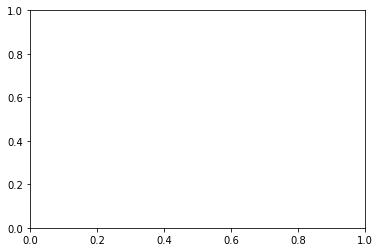

In [ ]:
plt.plot(range(len(loss_log)), loss_log)
plt.show()

In [ ]:
print(t_train.shape)
batch_size = 200
total_correct = 0

running_loss = 0.0
accuracy = 0.0
test_size = 1000
test_data_idx = np.random.choice(x_test.shape[0], test_size)
for i in tqdm(test_data_idx):
    x = x_test[i].reshape(1, 1, 28, 28)
    labels = t_test[i]

    outputs = model.forward(x)
    labels = labels.reshape(outputs.shape)
    c = (np.argmax(labels, 1) == np.argmax(outputs, 1)).squeeze()
    total_correct += np.sum(c)

print(f"Accuracy:{total_correct/test_size}")


(60000, 10)


100%|██████████| 1000/1000 [00:10<00:00, 95.30it/s]

Accuracy:0.981


In [ ]:
loss_log

[[0.8685447846838947],
 [0.974748666638959,
  0.70904474799902,
  0.668387099380597,
  0.9311568231315739,
  0.9875813066419978,
  0.9915942063026881,
  0.7446414217855859,
  0.8947772223060129,
  0.914543999091713,
  0.9125938993230096],
 [0.8542537324420817,
  0.9130112428504628,
  0.8419847191524624,
  0.8368279579901851,
  0.8804089419473665,
  0.609895316563449,
  0.5561483046388399,
  0.6553142597060525,
  0.6455818801577512,
  0.7925676214731671],
 [0.4985794771424321,
  0.63666482679869,
  0.6951424256149558,
  0.8042707863844143,
  0.6143679984843363,
  0.7196892863942425,
  0.5677317507957054,
  0.5302071605023799,
  0.6476010124671572,
  0.8715506144267248],
 [0.5278156262446533,
  0.7280703892433478,
  0.782962269305691,
  0.5702488688992853,
  0.6772801757678256,
  0.6081562258422408,
  0.6564509080865171,
  0.5564604636985427,
  0.5169910944569097,
  0.5875863641408327],
 [0.7001660992792712,
  0.47507111945156255,
  0.6586058980074996,
  0.515630680694363,
  0.5009723883